In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Starting block

In [ ]:
!pip install visualkeras

In [ ]:
!pip install lime

https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5

In [ ]:
'''Importing necessary libraries and modules'''

## Machine learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

## Supporting libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import gc
from sys import getsizeof
import datetime
import visualkeras
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Confusion Matrix and Classification report libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## GradCam libraries
from keras.models import Model

# Dataset Preparation and optimisation

In [ ]:
gc.enable()

In [ ]:
'''Importing files from drive'''

headpath = "/content/drive/MyDrive/Final Year Project/dataset 3"

In [ ]:
train = np.load(os.path.join(headpath,"train.npy"),allow_pickle=True)

In [ ]:
np.random.shuffle(train)

In [ ]:
train_features = [i[0] for i in train]
train_classes = [i[1] for i in train]
del(train)
gc.collect()

0

In [ ]:
test = np.load(os.path.join(headpath,"test.npy"),allow_pickle=True)

In [ ]:
np.random.shuffle(test)

In [ ]:
test_features = [i[0] for i in test]
test_classes = [i[1] for i in test]
del(test)
gc.collect()

0

In [ ]:
validation = np.load(os.path.join(headpath,"val.npy"),allow_pickle=True)

In [ ]:
np.random.shuffle(validation)

In [ ]:
validation_features = [i[0] for i in validation]
validation_classes = [i[1] for i in validation]
del(validation)
gc.collect()

0

In [ ]:
# valt = np.array(validation_classes)
# valt.flatten()
# for i in range(2):
#   print(np.count_nonzero(valt == i))

In [ ]:
label_list = ['abnormal', 'normal']

In [ ]:
X = np.array([np.array(val) for val in train_features])
Y = np.array(train_classes)
del(train_features,train_classes)

In [ ]:
A = np.array([np.array(val) for val in validation_features])
B = np.array(validation_classes)
del(validation_features,validation_classes)

In [ ]:
E = np.array([np.array(val) for val in test_features])
F = np.array(test_classes)
del(test_features,test_classes)
gc.collect()

0

# Models

In [ ]:
# Analytical Functions

class ModelAnalysis():
  global label_list
  def __init__(self,model,dataset,history):
    self.model = model
    self.train = dataset[0]
    self.validation = dataset[1]
    self.test = dataset[2]
    self.trainingCallback = history

  def postAnalysis(self):
    def plotAccuracy():
      plt.plot(self.trainingCallback.history['accuracy'])
      plt.plot(self.trainingCallback.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epochs')
      plt.yticks(np.arange(0,1.1,0.1))
      plt.legend(['Training', 'Validation'])
      plt.show()

    def plotLoss():
      plt.plot(self.trainingCallback.history['loss'])
      plt.plot(self.trainingCallback.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epochs')
      plt.legend(['Training', 'Validation'])
      plt.show()

    def testing():
      result = self.model.evaluate(self.test[0],self.test[1], batch_size=32,verbose=0)
      print(f'\nTesting: \nLoss = {result[0]} \nAccuracy = {result[1]*100:.4f}\n')
    
    def confusionMatrix():
      predictions = self.model.predict(self.test[0],verbose=0)
      predictions = np.argmax(predictions, axis=1)

      figsize = (12,12)
      ConfusionMatrixDisplay.from_predictions(self.test[1],predictions,cmap='Blues',display_labels=label_list, normalize='true', ax=plt.subplots(figsize=figsize)[1])
      print(classification_report(self.test[1], predictions))
    
    plotAccuracy()
    plotLoss()
    testing()
    confusionMatrix()

  def GradCamAnalysis(self,layers,eps=0.5,rnd=None):
    def GradCam(model, img_array, layer_name, eps=1e-8):
      '''
      Creates a grad-cam heatmap given a model and a layer name contained with that model
      

      Args:
        model: tf model
        img_array: (img_width x img_width) numpy array
        layer_name: str


      Returns 
        uint8 numpy array with shape (img_height, img_width)

      '''

      gradModel = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output,
          model.output])
      
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
      # use automatic differentiation to compute the gradients
      grads = tape.gradient(loss, convOutputs)
      
      # compute the guided gradients
      castConvOutputs = tf.cast(convOutputs > 0, "float32")
      castGrads = tf.cast(grads > 0, "float32")
      guidedGrads = castConvOutputs * castGrads * grads
      # the convolution and guided gradients have a batch dimension
      # (which we don't need) so let's grab the volume itself and
      # discard the batch
      convOutputs = convOutputs[0]
      guidedGrads = guidedGrads[0]
      # compute the average of the gradient values, and using them
      # as weights, compute the ponderation of the filters with
      # respect to the weights
      weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
      cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
      # grab the spatial dimensions of the input image and resize
      # the output class activation map to match the input image
      # dimensions
      (w, h) = (img_array.shape[2], img_array.shape[1])
      heatmap = cv2.resize(cam.numpy(), (w, h))
      # normalize the heatmap such that all values lie in the range
      # [0, 1], scale the resulting values to the range [0, 255],
      # and then convert to an unsigned 8-bit integer
      numer = heatmap - np.min(heatmap)
      denom = (heatmap.max() - heatmap.min()) + eps
      heatmap = numer / denom
      # heatmap = (heatmap * 255).astype("uint8")
      # return the resulting heatmap to the calling function
      return heatmap

    def sigmoid(x, a, b, c):
      return c / (1 + np.exp(-a * (x-b)))

    def superimpose(img_bgr, cam, thresh, emphasize=False):
      
      '''
      Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
      

      Args:
        image: (img_width x img_height x 3) numpy array
        grad-cam heatmap: (img_width x img_width) numpy array
        threshold: float
        emphasize: boolean

      Returns 
        uint8 numpy array with shape (img_height, img_width, 3)

      '''
      heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
      if emphasize:
          heatmap = sigmoid(heatmap, 50, thresh, 1)
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      
      hif = .8
      superimposed_img = heatmap * hif + img_bgr
      superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
      superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
      
      return superimposed_img_rgb

    #activation_layers = ['vgg.block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
    activation_layers = layers
    rnd = rnd if rnd != None else random.randint(0,int(E.shape[0]))
    print(rnd)
    img = self.test[0][rnd]
    plt.figure(figsize=(15, 15))
    for i, layer in enumerate(activation_layers):
      grad_cam = GradCam(self.model, np.expand_dims(img, axis=0), layer)
      ax = plt.subplot(7, 5, i +1)
      plt.imshow(grad_cam)
      plt.title(layer)
      plt.axis("off")
    plt.tight_layout()

    plt.figure(figsize=(15, 15))
    for i, layer in enumerate(activation_layers):
      grad_cam = GradCam(self.model, np.expand_dims(img, axis=0), layer)
      grad_cam_emphasized = superimpose(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), grad_cam, eps, emphasize=True)
      ax = plt.subplot(7, 5, i +1)
      plt.imshow(grad_cam_emphasized)
      plt.title(layer)
      plt.axis("off")
    plt.tight_layout()

  def saveModel(self,architecture):
    self.architecture = architecture
    timing = datetime.datetime.now()
    fname = f"Identification-model-currency-{self.architecture}-{timing.strftime('%d-%b-%Y-%I-%M')}.h5"
    self.model.save(os.path.join(headpath,'Model',fname))
  
  def visualiseModel(self,compact=False):
    if compact:
      return visualkeras.layered_view(self.model, legend=True,max_z=150)
    else:
      return visualkeras.layered_view(self.model, legend=True)

  def LimeAnalysis(self,model,rnd = None,samples=100):
    rnd = rnd if rnd != None else random.randint(0,int(E.shape[0]))
    print(rnd)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(self.test[0][rnd], self.model.predict,top_labels=3, hide_color=0, num_samples=samples)
    
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

## Simple CNN

In [ ]:
cnn_model = keras.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3),(2,2), activation='relu', input_shape=(200, 300,3),padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(512, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.GlobalAveragePooling2D())
# cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1500, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(750, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(350, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(180, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(90, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(45, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(2, activation='softmax'))

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 150, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 100, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 75, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 50, 75, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
cnn_model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer= tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
fit_model = cnn_model.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=10,shuffle=True)

Epoch 1/10
313/313 [==============================] - 18s 35ms/step - loss: 0.7312 - accuracy: 0.5548 - val_loss: 0.6623 - val_accuracy: 0.7070
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 0.6137 - accuracy: 0.6668 - val_loss: 0.5546 - val_accuracy: 0.7705
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 0.4585 - accuracy: 0.7875 - val_loss: 0.4114 - val_accuracy: 0.8455
Epoch 4/10
313/313 [==============================] - 11s 34ms/step - loss: 0.2989 - accuracy: 0.8774 - val_loss: 0.3265 - val_accuracy: 0.8855
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2016 - accuracy: 0.9267 - val_loss: 0.2630 - val_accuracy: 0.8945
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1426 - accuracy: 0.9516 - val_loss: 0.2945 - val_accuracy: 0.9045
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0972 - accuracy: 0.9706 - val_loss: 0.3587 - val_accuracy:

In [ ]:
CNN = ModelAnalysis(cnn_model,[(X,Y),(A,B),(E,F)],fit_model)

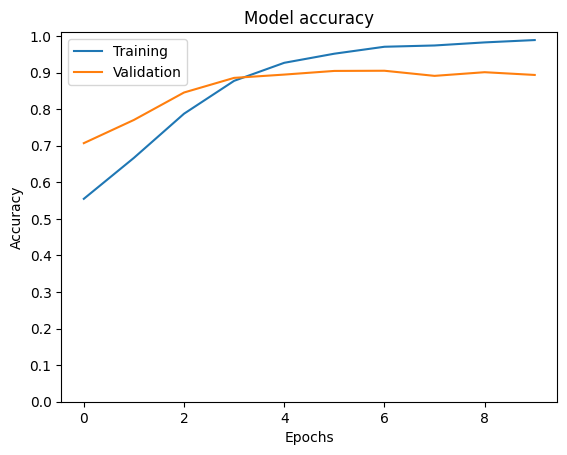

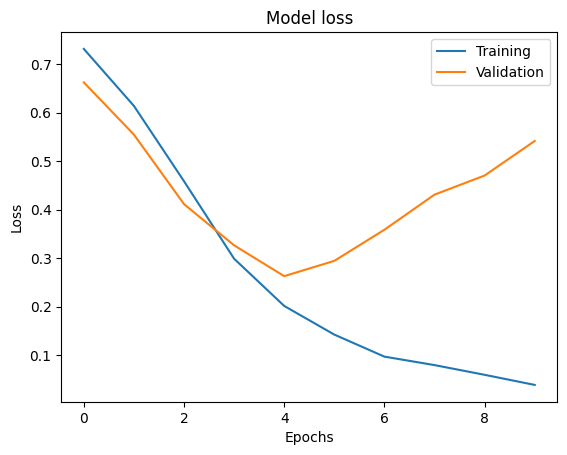


Testing: 
Loss = 1.8280458450317383 
Accuracy = 65.8000

              precision    recall  f1-score   support

           0       0.59      0.99      0.74      1000
           1       0.98      0.32      0.49      1000

    accuracy                           0.66      2000
   macro avg       0.79      0.66      0.61      2000
weighted avg       0.79      0.66      0.61      2000



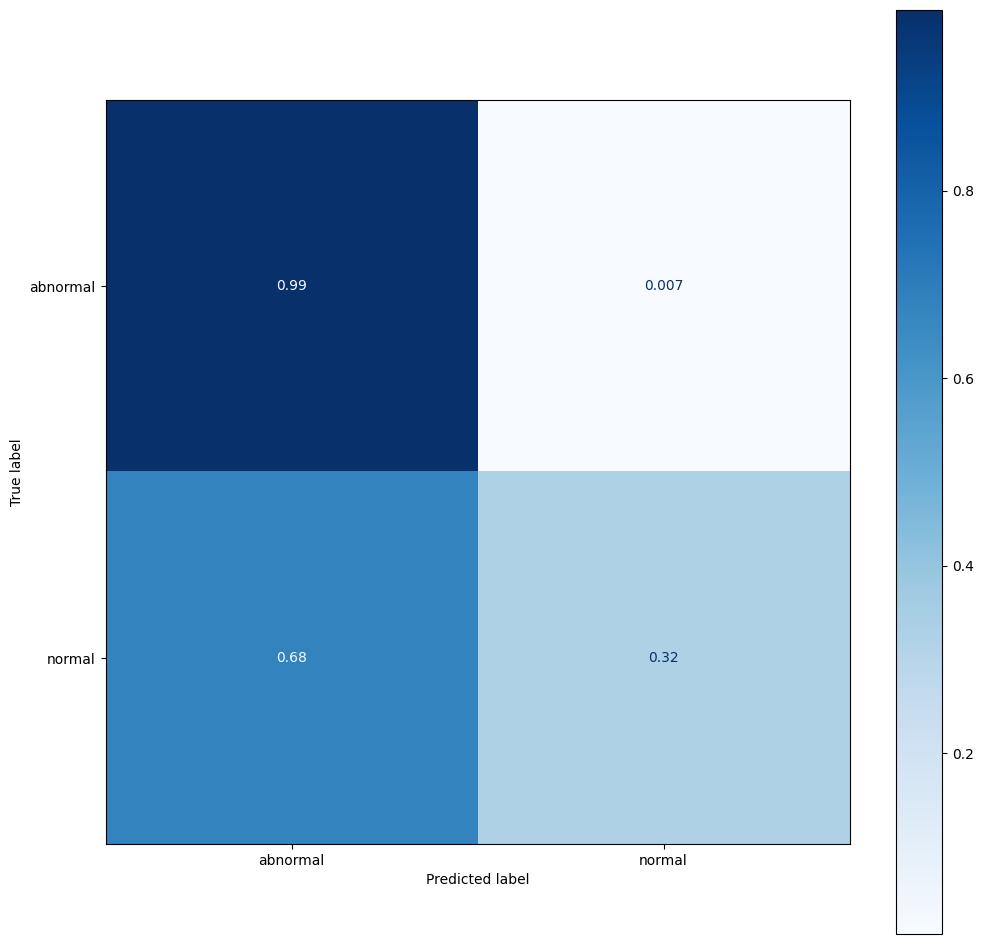

In [ ]:
CNN.postAnalysis()

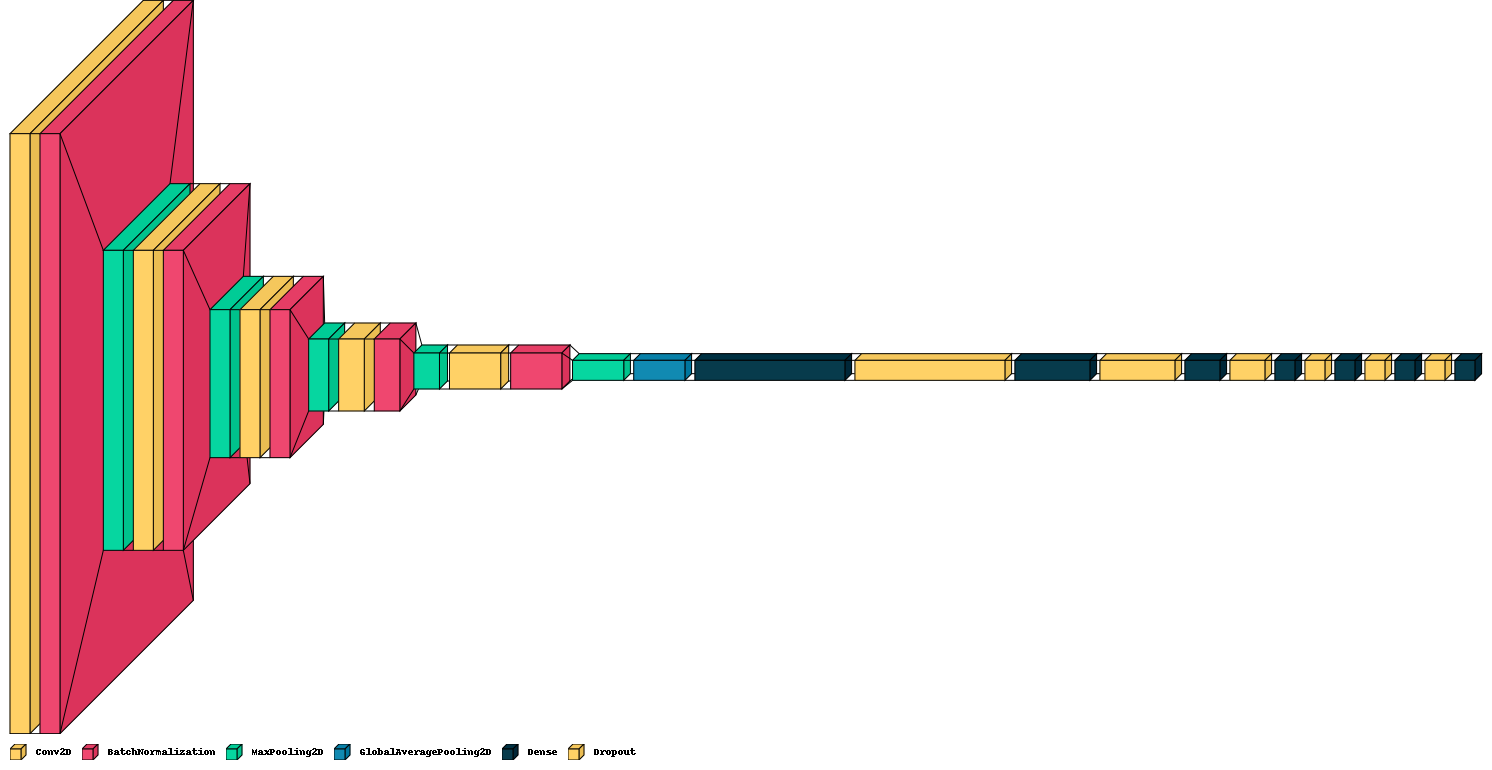

In [ ]:
CNN.visualiseModel(compact=True)

In [ ]:
CNN.saveModel('CNN')

## ResNet50V2

In [ ]:
resnetv2base = tf.keras.applications.ResNet50V2(input_shape=(200,300,3),weights='imagenet',include_top=False)

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
resnetv2base.trainable = False

In [ ]:
resnetv2base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
last_layer = resnetv2base.output

downlayers = tf.keras.layers.Flatten()(last_layer)
downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(2,activation='softmax')(downlayers)

resnetv2 = Model(inputs=resnetv2base.input, outputs=downlayers)

resnetv2.compile(optimizer= tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

In [ ]:
resnetv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history = resnetv2.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=10,shuffle=True)

Epoch 1/10
313/313 [==============================] - 56s 139ms/step - loss: 14.6698 - accuracy: 0.8664 - val_loss: 16.2427 - val_accuracy: 0.8300
Epoch 2/10
313/313 [==============================] - 43s 136ms/step - loss: 5.3599 - accuracy: 0.9414 - val_loss: 23.6386 - val_accuracy: 0.8155
Epoch 3/10
313/313 [==============================] - 39s 125ms/step - loss: 3.3294 - accuracy: 0.9618 - val_loss: 14.5824 - val_accuracy: 0.8705
Epoch 4/10
313/313 [==============================] - 43s 139ms/step - loss: 2.0542 - accuracy: 0.9743 - val_loss: 23.3484 - val_accuracy: 0.8360
Epoch 5/10
313/313 [==============================] - 43s 138ms/step - loss: 1.5058 - accuracy: 0.9797 - val_loss: 20.6634 - val_accuracy: 0.8560
Epoch 6/10
313/313 [==============================] - 43s 139ms/step - loss: 1.1602 - accuracy: 0.9845 - val_loss: 19.9231 - val_accuracy: 0.8585
Epoch 7/10
313/313 [==============================] - 43s 139ms/step - loss: 0.9770 - accuracy: 0.9861 - val_loss: 20.9856 

In [ ]:
RESNET50V2 = ModelAnalysis(resnetv2,[(X,Y),(A,B),(E,F)],history)

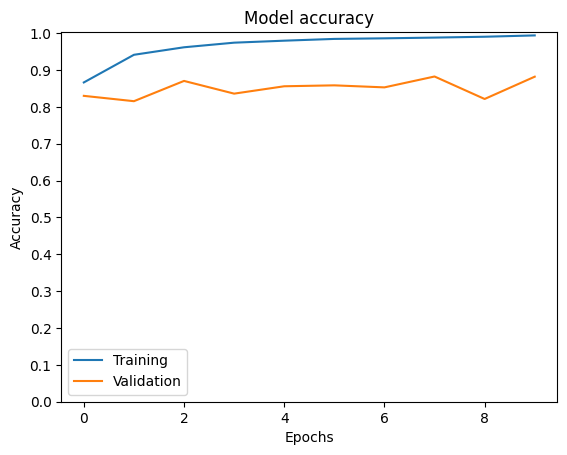

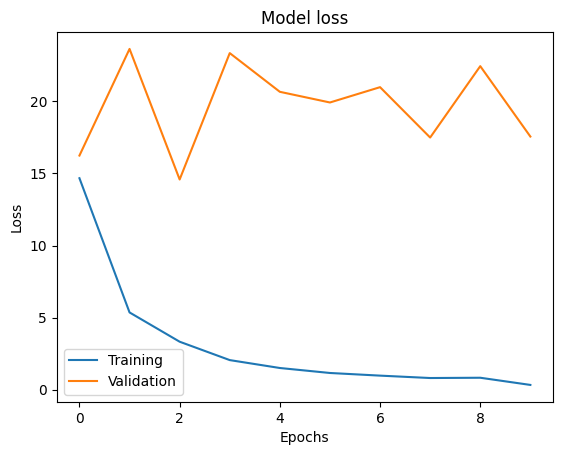


Testing: 
Loss = 28.532474517822266 
Accuracy = 72.8000

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1000
           1       1.00      0.46      0.63      1000

    accuracy                           0.73      2000
   macro avg       0.82      0.73      0.71      2000
weighted avg       0.82      0.73      0.71      2000



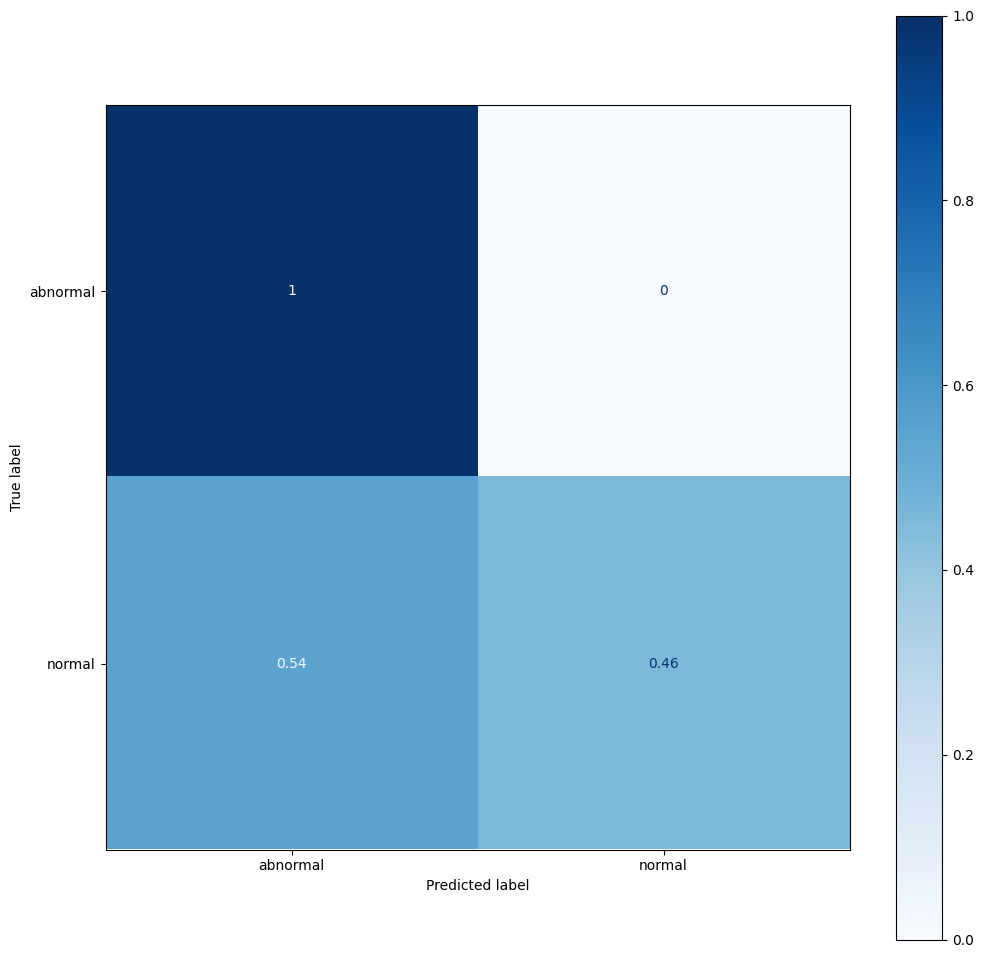

In [ ]:
RESNET50V2.postAnalysis()

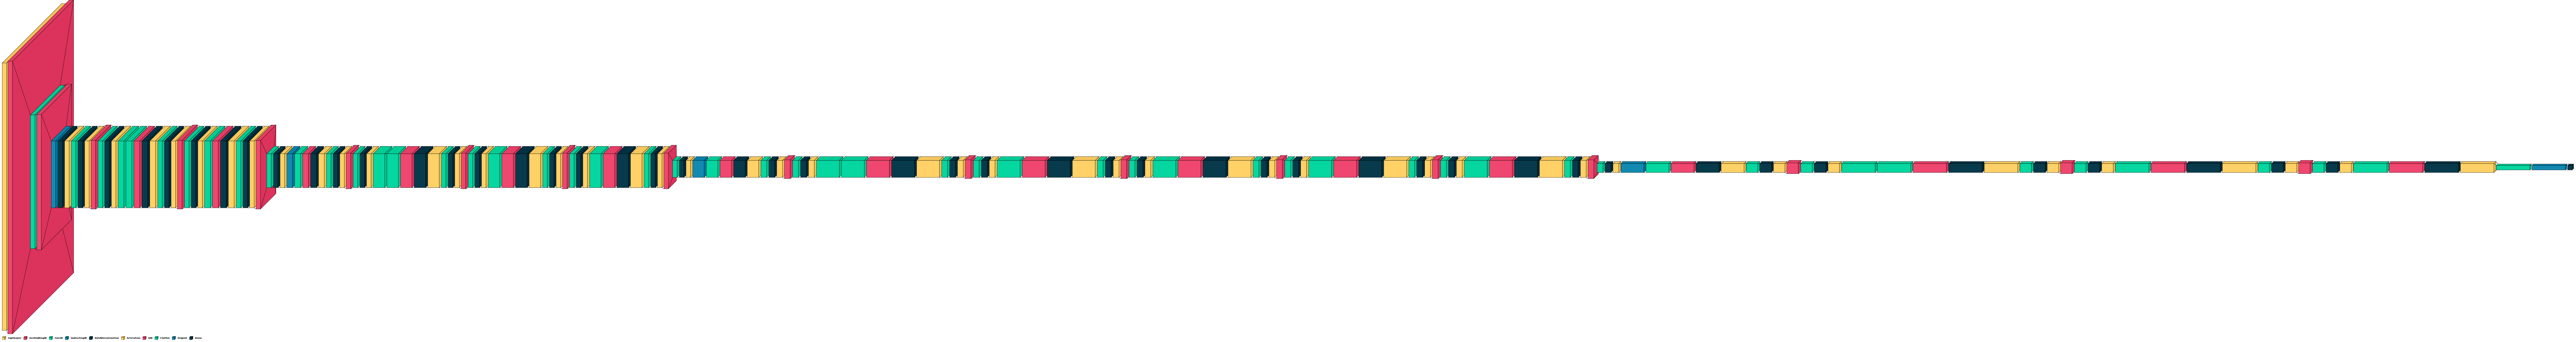

In [ ]:
RESNET50V2.visualiseModel(compact=True)

## VGG19

In [ ]:
vgg19base = tf.keras.applications.VGG19(input_shape=(200,300,3),weights='imagenet',include_top=False)
vgg19base.trainable = False 

In [ ]:
vgg19base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 75, 128)       0     

In [ ]:
last_layer = vgg19base.output

downlayers = tf.keras.layers.Flatten()(last_layer)

# downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
# downlayers = tf.keras.layers.Dense(512,activation='relu')(downlayers)

downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(128,activation='relu')(downlayers)

# downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
# downlayers = tf.keras.layers.Dense(32,activation='relu')(downlayers)

downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(2,activation='softmax')(downlayers)

vgg19 = Model(inputs=vgg19base.input, outputs=downlayers)

vgg19.compile(optimizer= tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

In [ ]:
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 75, 128)       0     

In [ ]:
vgg19fit = vgg19.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=10,shuffle=True)

Epoch 1/10
313/313 [==============================] - 98s 262ms/step - loss: 1.6255 - accuracy: 0.8796 - val_loss: 2.1833 - val_accuracy: 0.8225
Epoch 2/10
313/313 [==============================] - 74s 238ms/step - loss: 0.2765 - accuracy: 0.9725 - val_loss: 2.1882 - val_accuracy: 0.8195
Epoch 3/10
313/313 [==============================] - 83s 264ms/step - loss: 0.1205 - accuracy: 0.9873 - val_loss: 2.5862 - val_accuracy: 0.7870
Epoch 4/10
313/313 [==============================] - 83s 265ms/step - loss: 0.0836 - accuracy: 0.9910 - val_loss: 2.7167 - val_accuracy: 0.7820
Epoch 5/10
313/313 [==============================] - 75s 239ms/step - loss: 0.0481 - accuracy: 0.9934 - val_loss: 2.5978 - val_accuracy: 0.7925
Epoch 6/10
313/313 [==============================] - 82s 264ms/step - loss: 0.0376 - accuracy: 0.9955 - val_loss: 2.0769 - val_accuracy: 0.8060
Epoch 7/10
313/313 [==============================] - 83s 265ms/step - loss: 0.0136 - accuracy: 0.9971 - val_loss: 1.9332 - val_ac

In [ ]:
VGG19 = ModelAnalysis(vgg19,[(X,Y),(A,B),(E,F)],vgg19fit)

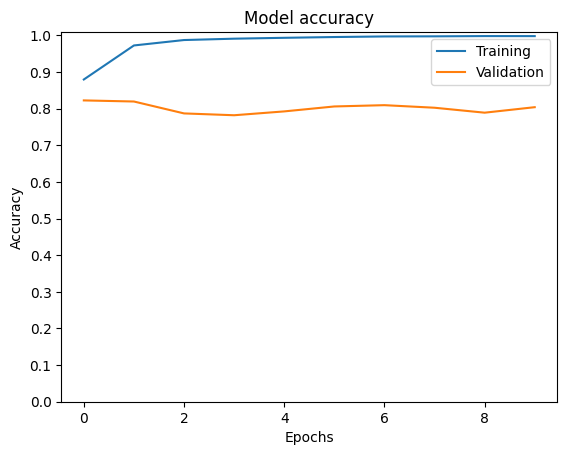

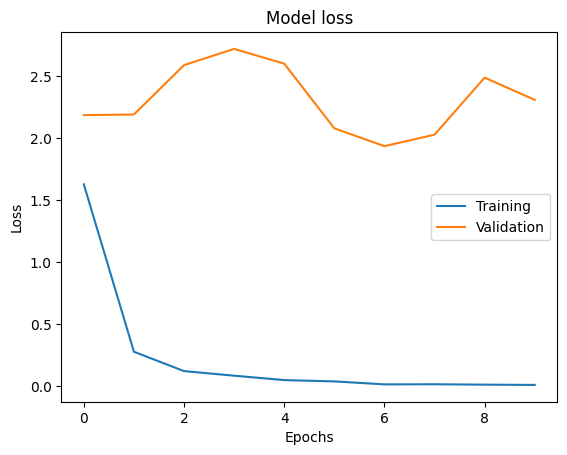


Testing: 
Loss = 4.402922630310059 
Accuracy = 73.1000

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1000
           1       1.00      0.46      0.63      1000

    accuracy                           0.73      2000
   macro avg       0.83      0.73      0.71      2000
weighted avg       0.83      0.73      0.71      2000



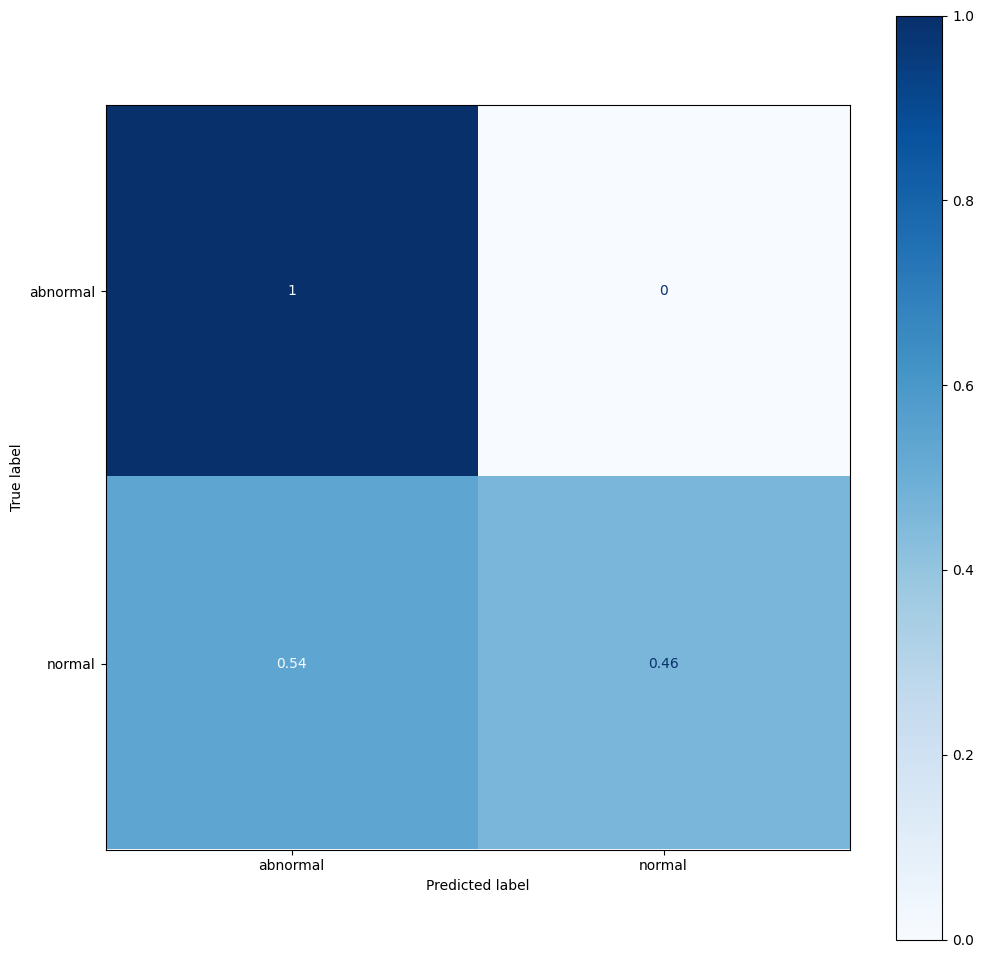

In [ ]:
VGG19.postAnalysis()

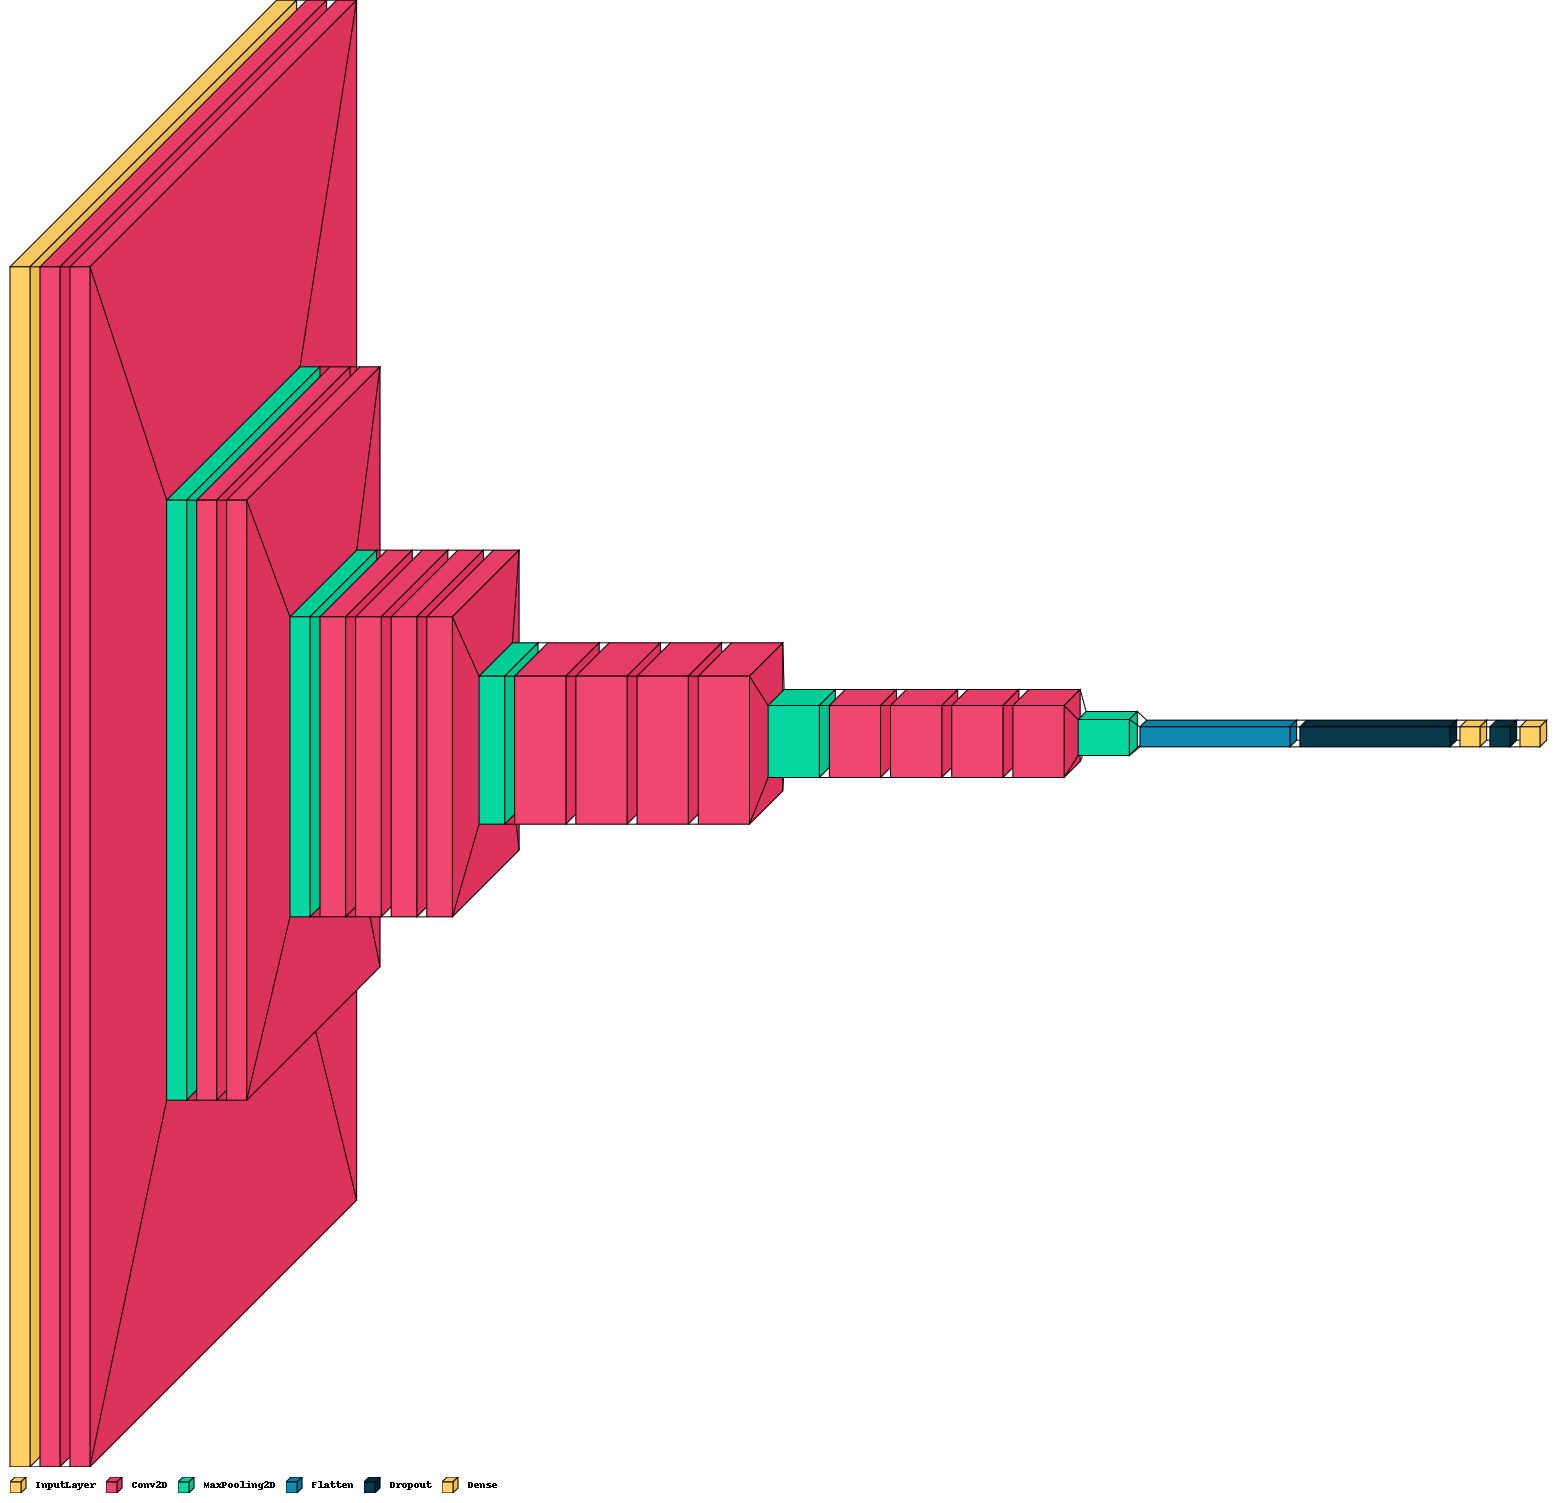

In [ ]:
VGG19.visualiseModel(compact=True)

In [ ]:
# wtf = tf.keras.models.load_model('vgg19.h5') 

In [ ]:
vgg19.save('vgg19.h5')

# Rest of testing 

## Image Testing

In [ ]:
# Testing Single Image

test_img = cv2.imread("validation_1.png")
test_img = np.squeeze(test_img)
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(300,200))
show_img = test_img.copy()
# test_img =  E[400]
# show_img = test_img
test_img = np.array([np.array(test_img)])

y_out = vgg19.predict(test_img)
y_out = y_out*100
# print(y_out)
index = np.argmax(y_out)
plt.imshow(show_img)
label = f"{label_list[np.argmax(y_out)]} : {y_out[0][index]:.2f}%"
plt.title(label)

In [ ]:
# Testing Multiple Images

images = os.listdir()
for i in [".config","drive",'.ipynb_checkpoints','sample_data']:
  try:
    images.remove(i)
  except Exception:
    pass

#images = [ E[random.randint(0,int(E.shape[0]))] for i in range(10)]
for i in images:
  # print(i)
  test_img = cv2.imread(i)
  #test_img = i
  try:
    if test_img.shape[0] > test_img.shape[1]:
      test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
    test_img = np.squeeze(test_img)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(300,200))
    show_img = test_img.copy()
    test_img = np.array([np.array(test_img)])

    y_out = vgg19.predict(test_img)
    plt.figure()
    plt.imshow(show_img)
    y_out = y_out*100
    index = np.argmax(y_out)
    label = f"{label_list[np.argmax(y_out)]} : {y_out[0][index]:.2f}%"
    

    plt.title(label)
    plt.show()
  except Exception:
    print(f"Error happend for image {i}")
    continue